In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Select data for all ICU admissions
query = \
"""
SELECT
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    p.gender,
    p.dob,
    ROUND((CAST(a.admittime AS date) - CAST(p.dob AS date))/365.242,2) AS age,
    a.admittime,
    a.dischtime,
    i.intime,
    i.outtime,
    i.los,
    a.diagnosis,
    a.hospital_expire_flag
FROM
    icustays i
    INNER JOIN patients p ON i.subject_id = p.subject_id
    INNER JOIN admissions a ON p.subject_id = a.subject_id
"""

# Execute the query and fetch the result
cur = conn.cursor()
cur.execute(query)
conn.commit()
data = cur.fetchall()

# Store the result of the query as a pandas dataframe
labels = ['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dob', 'age', 'admittime', 'dischtime', 'intime', 'outtime', 'icu_los', 'diagnosis', 'hosp_expire_flag']
icu = pd.DataFrame(data, columns=labels)

In [4]:
# Show some sample data
icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,icu_los,diagnosis,hosp_expire_flag
0,2,163353,243653,M,2138-07-17,0.00,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918,NEWBORN,0
1,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0
2,4,185777,294638,F,2143-05-12,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,214757,M,2103-02-02,0.00,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844,NEWBORN,0
4,6,107064,228232,F,2109-06-21,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,CHRONIC RENAL FAILURE/SDA,0


In [5]:
# Print some statistics about the patient population
icu.head()
print('No. of subject_id: {}'.format(len(np.unique(icu['subject_id']))))
print('No. of hadm_id: {}'.format(len(np.unique(icu['hadm_id']))))
print('No. of icustay_id: {}'.format(len(np.unique(icu['icustay_id']))))

No. of subject_id: 46476
No. of hadm_id: 57786
No. of icustay_id: 61532


In [6]:
# Remove any patients under 18 years old
adult_icu = icu[icu['age']>=18]
print('ICU stays with patients over 18: {}'.format(len(adult_icu)))

ICU stays with patients over 18: 107843


In [7]:
# Select first ICU admission for each patient
icu_sorted = adult_icu.sort_values(by=['subject_id', 'intime']) # sort patients by subject ID and ICU admission time
adult_first_icu = icu_sorted.groupby('subject_id', as_index=False).first() # take the first ICU admission for each subject
print('Adults admitted to ICU for the first time: {}'.format(len(adult_first_icu)))

Adults admitted to ICU for the first time: 38512


In [8]:
# Show some sample data for adult first ICU admission
adult_first_icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,icu_los,diagnosis,hosp_expire_flag
0,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0
1,4,185777,294638,F,2143-05-12,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
2,6,107064,228232,F,2109-06-21,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,CHRONIC RENAL FAILURE/SDA,0
3,9,150750,220597,M,2108-01-26,41.79,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,HEMORRHAGIC CVA,1
4,11,194540,229441,F,2128-02-22,50.15,2178-04-16 06:18:00,2178-05-11 19:00:00,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,BRAIN MASS,0


C:\Users\anear\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\anear\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


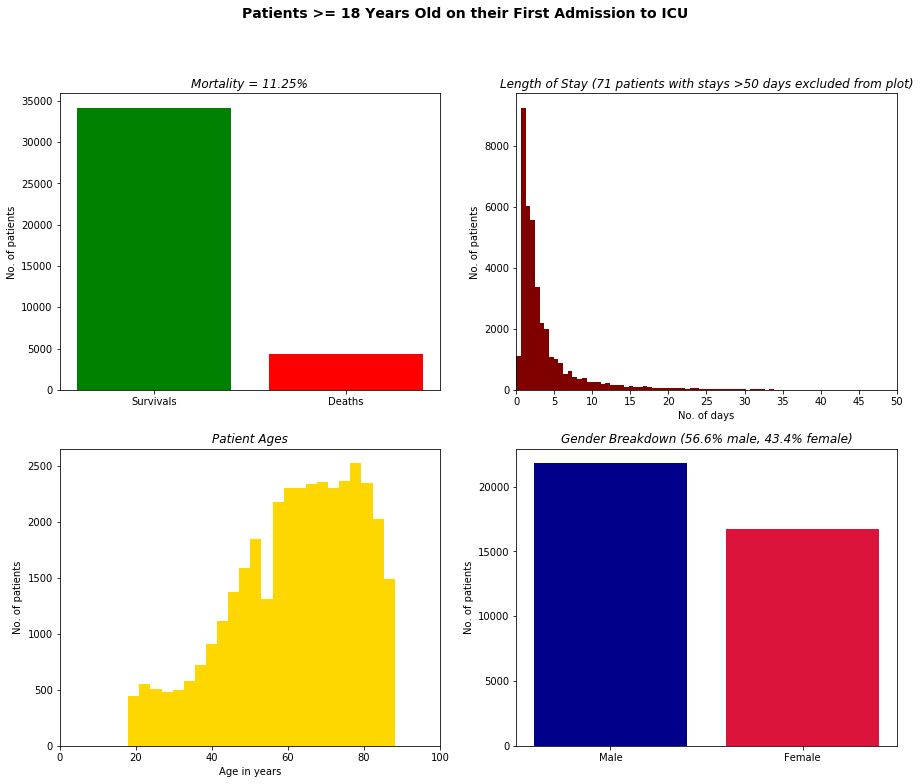

In [9]:
# Visualise mortality rate and length of ICU stay
fig, axs = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Patients >= 18 Years Old on their First Admission to ICU', weight='semibold', fontsize=14)

# Plot the mortality
axs[0,0].bar(x=['Survivals','Deaths'], height=[len(adult_first_icu)-sum(adult_first_icu['hosp_expire_flag']),sum(adult_first_icu['hosp_expire_flag'])], color=['g','r'])
axs[0,0].set_title('Mortality = {:.2f}%'.format(100*sum(adult_first_icu['hosp_expire_flag'])/len(adult_first_icu)), style='italic')
axs[0,0].set_ylabel('No. of patients')

# Plot the length of stay
axs[0,1].hist(x=adult_first_icu['icu_los'], bins=250, color='maroon')
axs[0,1].set_title('Length of Stay (71 patients with stays >50 days excluded from plot)', style='italic')
axs[0,1].set_xlim([0,50])
axs[0,1].set_xticks(range(0,51,5))
axs[0,1].set_xlabel('No. of days')
axs[0,1].set_ylabel('No. of patients')

# Plot the patient ages
axs[1,0].hist(x=adult_first_icu['age'].astype('int64'), bins=100, color='gold')
axs[1,0].set_title('Patient Ages', style='italic')
axs[1,0].set_xlim([0,100])
axs[1,0].set_xlabel('Age in years')
axs[1,0].set_ylabel('No. of patients')

# Plot the gender breakdown
axs[1,1].bar(x=['Male','Female'], height=[sum(adult_first_icu['gender']=='M'),sum(adult_first_icu['gender']=='F')], color=['darkblue','crimson'])
axs[1,1].set_title('Gender Breakdown ({:.1f}% male, {:.1f}% female)'.format(100*sum(adult_first_icu['gender']=='M')/len(adult_first_icu), 100*sum(adult_first_icu['gender']=='F')/len(adult_first_icu)), style='italic')
axs[1,1].set_ylabel('No. of patients');

In [11]:
# Sort patients by subject_id, then hadm_id and icustay_id if needed
adult_first_icu.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'])

# Save to patients.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'patients': adult_first_icu}
np.save('data/patients.npy',tosave)
print("Saved!")

Saved!
